# Processing the Dataset

In [3]:
# # run only to verify the dataset read op
# import numpy as np
# import pandas as pd

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/intel-image-classification'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [6]:
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.15.0


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [21]:
data_dir = "/kaggle/input/seg_train/seg_train/"
test_data_dir = "/kaggle/input/seg_test/seg_test/"

num_classes = 6
img_width = 150
img_height = 150
batch_size = 64
seed = 1

In [22]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [23]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [24]:
val_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [25]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    seed=seed,
    shuffle=False,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 3000 images belonging to 6 classes.


In [26]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

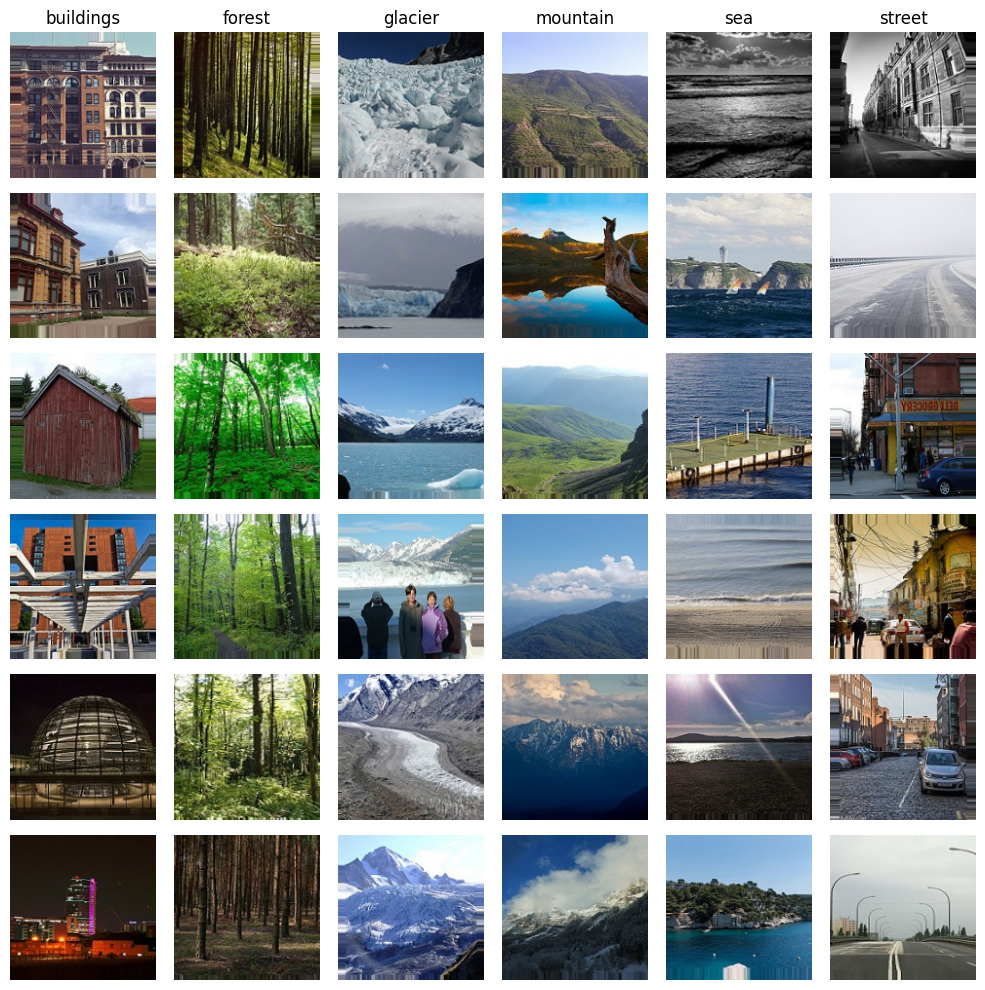

In [27]:
import matplotlib.pyplot as plt
import numpy as np

class_labels = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(6, 6, figsize=(10, 10))

for i, class_label in enumerate(class_labels):
    images, _ = next(iter(train_generator))
    
    # Get indices of images belonging to the current class
    class_indices = np.where(np.argmax(_, axis=1) == i)[0]
    
    # Get random indices for selecting 6 images
    random_indices = np.random.choice(class_indices, 6, replace=False)
    
    for j, index in enumerate(random_indices):
        # Display the j-th randomly selected image of the current class in the corresponding subplot
        ax = axes[j, i]
        ax.imshow(images[index])
        ax.axis('off')
        if j == 0:
            ax.set_title(class_label)

plt.tight_layout()
plt.show()

# Commonly used function definitions

In [28]:
def plot_learning_curve(history_):
    training_loss = history_.history['loss']
    validation_loss = history_.history['val_loss']
    training_accuracy = history_.history['accuracy']
    validation_accuracy = history_.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [29]:
def evaluate_on_test_dataset(model_):
    test_loss, test_accuracy = model_.evaluate(test_generator)
    print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

In [30]:
# this test set is to find the worst classified example (without having to use the test_generator)
test_set = list()
for i in range(47):
    x_, y_ = test_generator[i]
    test_set.extend(zip(x_, y_))

In [36]:
def plot_worst_classified_examples(preds):    
    # Find misclassified examples
    worst_misclassifications = dict()
    for i, (x, y_true) in enumerate(test_set):
        pred_label = np.argmax(preds[i])
        true_label = np.argmax(y_true)
        if pred_label != true_label:
            prob_diff = preds[i][pred_label] - preds[i][true_label]
            if true_label not in worst_misclassifications:
                worst_misclassifications[true_label] = (x, prob_diff, pred_label)
            else:
                if worst_misclassifications[true_label][1] < prob_diff:
                    worst_misclassifications[true_label] = (x, prob_diff, pred_label)

#     # prints images 1 by 1
#     for key, value in worst_misclassifications.items():
#         true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
#         pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[1])
#         plt.imshow(value[0])
#         plt.title(f"True: {true_lbl}, Pred: {pred_lbl}")
#         plt.axis('off')
#         plt.show()
    
    # prints images as subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    for idx, (key, value) in enumerate(worst_misclassifications.items()):
        true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
        pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[2])
        
        r, c = (0, idx) if idx <= 2 else (1, idx-3)
        axs[r, c].imshow(value[0])
        axs[r, c].set_title(f"True: {true_lbl}, Pred: {pred_lbl}")
        axs[r, c].axis('off')

    plt.tight_layout()
    plt.show()

# 1. Fine-tune ResNet50 (default lr, epochs=60)

In [37]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [38]:
x = base_model.output
x = GlobalAvgPool2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [39]:
model = Model(inputs=base_model.input, outputs=predictions)

In [40]:
for layer in base_model.layers:
    layer.trainable = False

In [41]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
)

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/176 ━━━━━━━━━━━━━━━━━━━━ 1:19:20 27s/step - accuracy: 0.1719 - loss: 1.7453

I0000 00:00:1712641707.421217     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712641707.484912     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/176 ━━━━━━━━━━━━━━━━━━━━ 36s 887ms/step - accuracy: 0.2959 - loss: 1.7116

W0000 00:00:1712641826.246096     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.3139 - loss: 1.6710

W0000 00:00:1712641863.562012     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.3143 - loss: 1.6701 - val_accuracy: 0.4693 - val_loss: 1.2954
Epoch 2/60


W0000 00:00:1712641907.223053     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 113s 626ms/step - accuracy: 0.4934 - loss: 1.2673 - val_accuracy: 0.5025 - val_loss: 1.1830
Epoch 3/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 597ms/step - accuracy: 0.5458 - loss: 1.1369 - val_accuracy: 0.5988 - val_loss: 1.0626
Epoch 4/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 110s 605ms/step - accuracy: 0.5526 - loss: 1.0968 - val_accuracy: 0.5934 - val_loss: 1.0234
Epoch 5/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 111s 608ms/step - accuracy: 0.5839 - loss: 1.0439 - val_accuracy: 0.6102 - val_loss: 1.0186
Epoch 6/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 113s 623ms/step - accuracy: 0.5953 - loss: 1.0184 - val_accuracy: 0.5902 - val_loss: 1.0300
Epoch 7/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 108s 593ms/step - accuracy: 0.6047 - loss: 1.0006 - val_accuracy: 0.6038 - val_loss: 0.9832
Epoch 8/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 113s 625ms/step - accuracy: 0.6293 - loss: 0.9392 - val_accuracy: 0.5717 - val_loss: 1.0097
Epoch 10/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 601ms/step - accuracy: 0.6121 - loss: 0.9

In [43]:
evaluate_on_test_dataset(model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 736ms/step - accuracy: 0.7388 - loss: 0.7018
Test Loss: 0.7866258025169373
Test Accuracy: 0.6903333067893982


W0000 00:00:1712648552.341141     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


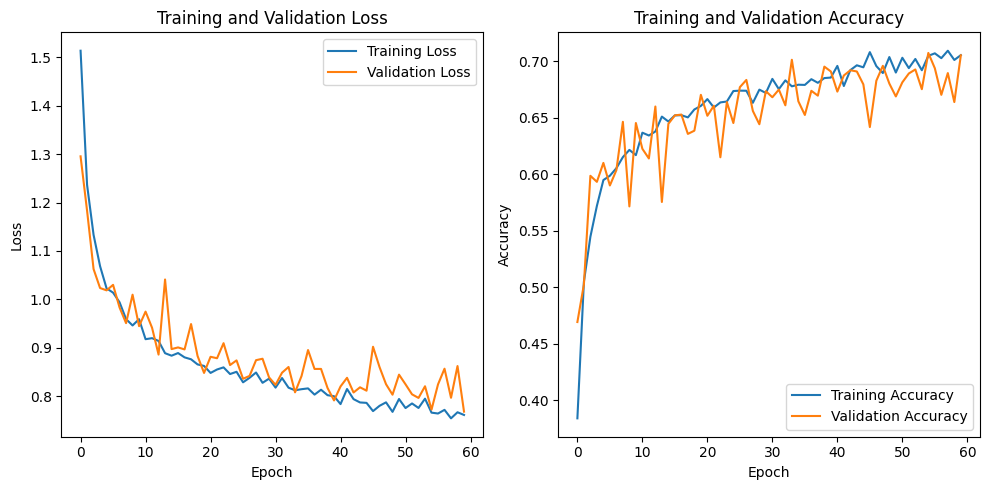

In [44]:
plot_learning_curve(history)

In [45]:
predictions = model.predict(test_generator)

 2/47 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step

W0000 00:00:1712648558.140027     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 537ms/step


W0000 00:00:1712648582.853930     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


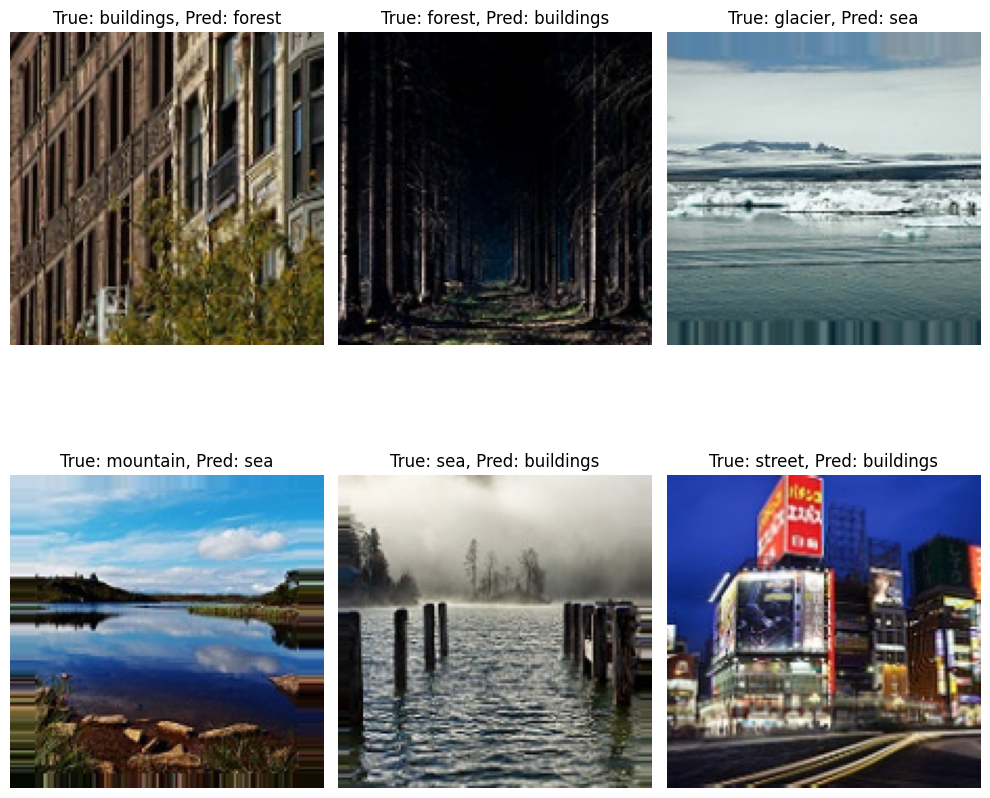

In [46]:
plot_worst_classified_examples(predictions)

# 2. Fine-tune InceptionV3 (default lr, epochs=60)

In [47]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model2 = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [48]:
x2 = base_model2.output
x2 = GlobalAvgPool2D()(x2)
x2 = Dense(1024, activation='relu')(x2)
predictions2 = Dense(num_classes, activation='softmax')(x2)

In [49]:
model2 = Model(inputs=base_model2.input, outputs=predictions2)

In [50]:
for layer in base_model2.layers:
    layer.trainable = False

In [51]:
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history2 = model2.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
)

Epoch 1/60
  2/176 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.1328 - loss: 3.3246   

W0000 00:00:1712649177.948450     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/176 ━━━━━━━━━━━━━━━━━━━━ 20s 603ms/step - accuracy: 0.7090 - loss: 1.2420

W0000 00:00:1712649262.836408     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.7304 - loss: 1.1252

W0000 00:00:1712649285.085150     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 168s 810ms/step - accuracy: 0.7315 - loss: 1.1192 - val_accuracy: 0.8787 - val_loss: 0.3699
Epoch 2/60


W0000 00:00:1712649319.737979     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 110s 605ms/step - accuracy: 0.8824 - loss: 0.3442 - val_accuracy: 0.8723 - val_loss: 0.3554
Epoch 3/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 112s 619ms/step - accuracy: 0.8948 - loss: 0.2918 - val_accuracy: 0.8780 - val_loss: 0.3346
Epoch 4/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 602ms/step - accuracy: 0.9011 - loss: 0.2622 - val_accuracy: 0.8816 - val_loss: 0.3478
Epoch 5/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 107s 586ms/step - accuracy: 0.9036 - loss: 0.2567 - val_accuracy: 0.8909 - val_loss: 0.3100
Epoch 6/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 104s 575ms/step - accuracy: 0.9104 - loss: 0.2421 - val_accuracy: 0.8884 - val_loss: 0.3100
Epoch 7/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 580ms/step - accuracy: 0.9139 - loss: 0.2312 - val_accuracy: 0.8823 - val_loss: 0.3341
Epoch 8/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 104s 573ms/step - accuracy: 0.9141 - loss: 0.2282 - val_accuracy: 0.8770 - val_loss: 0.3594
Epoch 9/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 104s 573ms/step - accuracy: 0.9221 - loss: 0.21

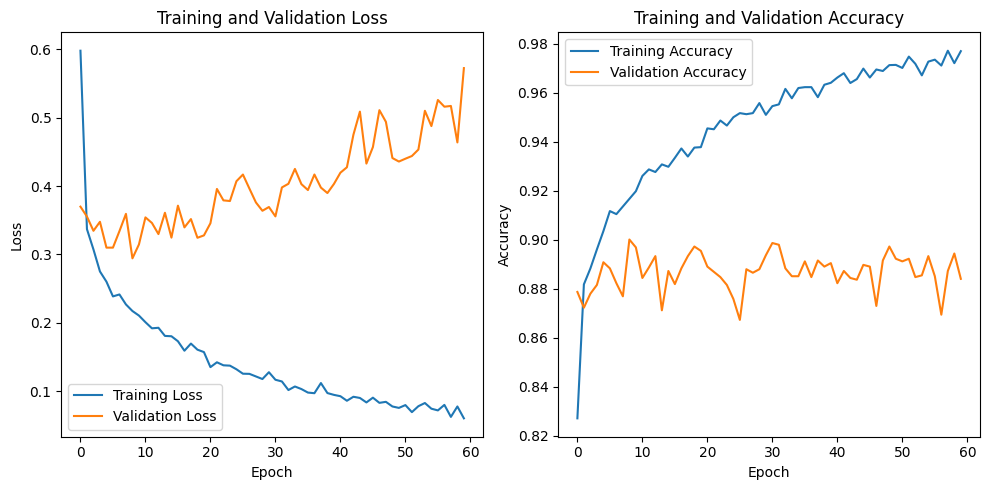

In [53]:
plot_learning_curve(history2)

In [54]:
evaluate_on_test_dataset(model2)

47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 804ms/step - accuracy: 0.8890 - loss: 0.5191
Test Loss: 0.5354935526847839
Test Accuracy: 0.8893333077430725


W0000 00:00:1712655557.776826     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [55]:
predictions2 = model2.predict(test_generator)

 1/47 ━━━━━━━━━━━━━━━━━━━━ 4:50 6s/step

W0000 00:00:1712655565.065616     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 571ms/step


W0000 00:00:1712655591.341692     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


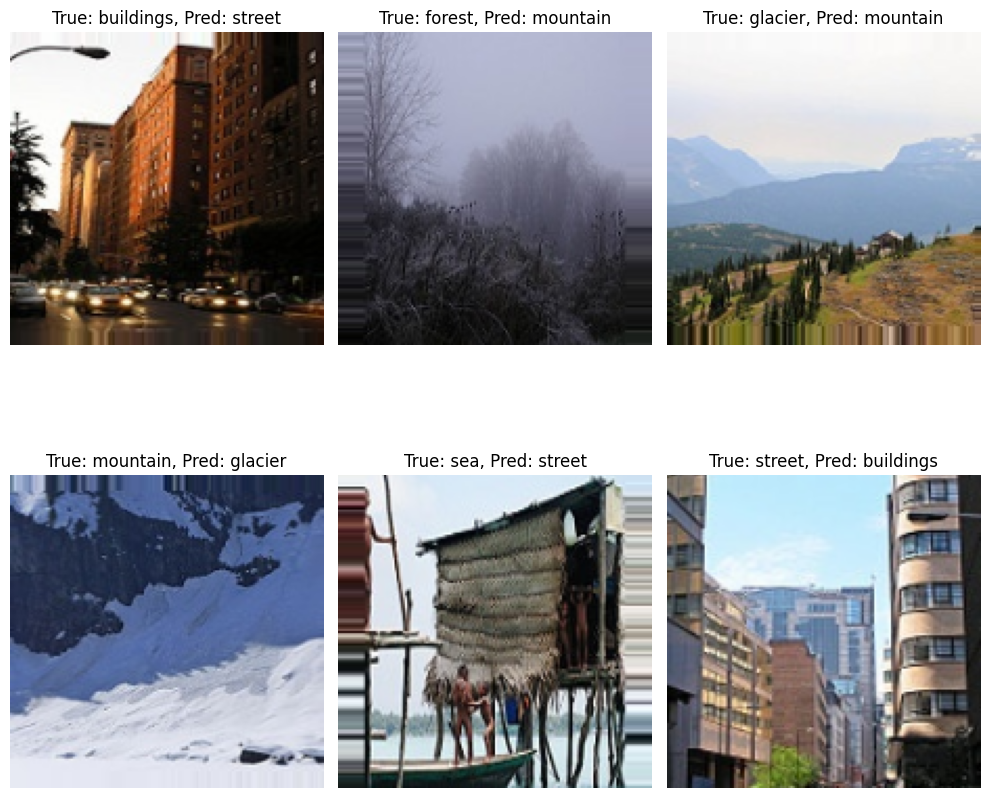

In [56]:
plot_worst_classified_examples(predictions2)